In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os

from utils import *

In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
projects = ["mc_vs_td_generalized"]
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True

## Plotting

In [4]:

def grouping_func(config):
    result = ''
    if config['agent']['is_td']:
        result += 'td'
    else:
        result += 'mc'

    if config['agent']['agent_name'] == 'gcdqn':
        result += '_dqn'
    else:
        result += '_clearn'

    if config['agent']['net_arch'] =='mlp':
        result += '_small'
    else:
        result += '_big'

    return result


In [ ]:
config_mc_vs_td_small_grid = {
    "title": "mc_vs_td_generalized_3_boxes_2_movable_4_grid",
    "projects":["mc_vs_td_generalized"],
    "possible_names":['td_dqn_big', 'mc_dqn_big', 'td_clearn_big', 'mc_clearn_big', 'td_dqn_small', 'mc_dqn_small', 'td_clearn_small', 'mc_clearn_small'],
    "filters":{
        "config.env.grid_size": 4,
        "config.env.number_of_boxes_max":3,
        "config.env.number_of_moving_boxes_max":2,
    },
    "grouping_func": grouping_func,
    "metrics":["eval/mean_success", "eval_3/mean_success", "eval/mean_boxes_on_target", "eval_3/mean_boxes_on_target"]
}

config_mc_vs_td_big_grid = {
    "title": "mc_vs_td_generalized_3_boxes_2_movable_6_grid",
    "projects":["mc_vs_td_generalized"],
    "possible_names":['td_dqn_big', 'mc_dqn_big', 'td_clearn_big', 'mc_clearn_big', 'td_dqn_small', 'mc_dqn_small', 'td_clearn_small', 'mc_clearn_small'],
    "filters":{
        "config.env.grid_size": 6,
        "config.env.number_of_boxes_max":3,
        "config.env.number_of_moving_boxes_max":2,
    },
    "grouping_func": grouping_func,
    "metrics":["eval/mean_success", "eval_3/mean_success", "eval/mean_boxes_on_target", "eval_3/mean_boxes_on_target"]
}


In [6]:
all_configs = [config_mc_vs_td_small_grid, config_mc_vs_td_big_grid]

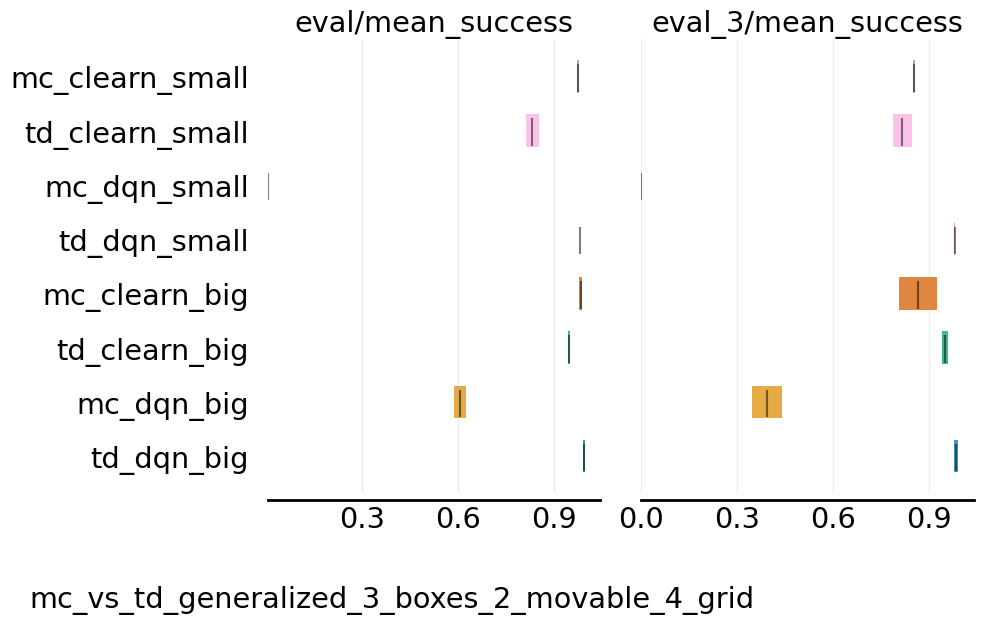

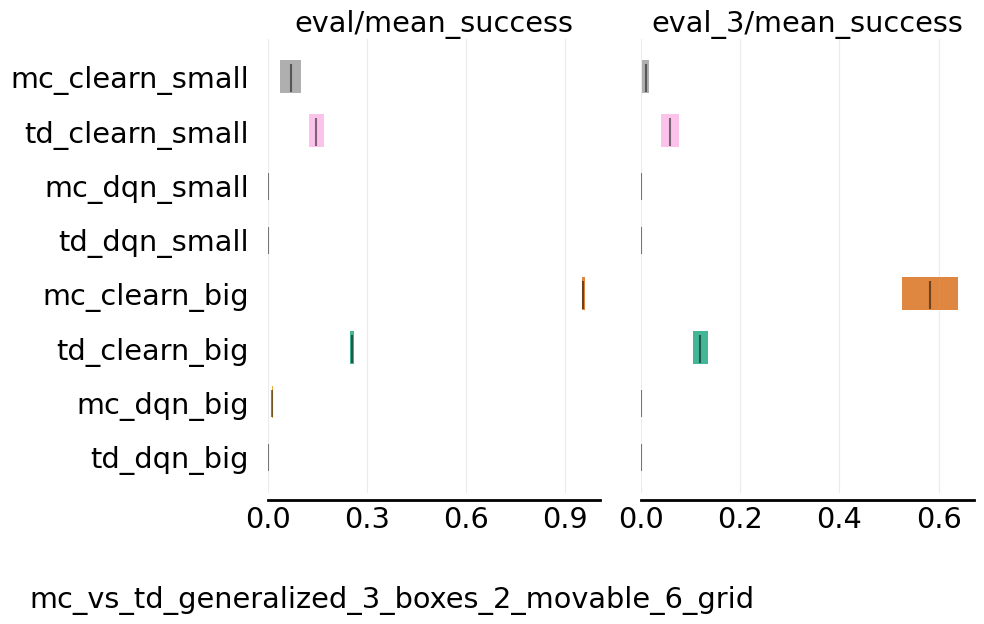

In [7]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

    # print(len(runs))
    # for r in runs:
    #     print(r.name)

    run_hist = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'])
    draw_interval_estimates_plot(run_hist, config['possible_names'], config['metrics'], config['title'], figures_path=figures_path)

In [8]:
# # for group, group_data in run_hist.items():
# #     print(group)
# #     print(group_data)
# thresholds = np.linspace(0.0, 1, 41)
# score_distributions, score_distributions_cis = rly.create_performance_profile(
#     run_hist, thresholds
# )

# frames = np.arange(0, 20, 1)
# frames[-1] -= 1
# ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score in run_hist.items()}
# iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])])
# iqm_scores, iqm_cis = rly.get_interval_estimates(ale_frames_scores_dict, iqm, reps=2000)

# plot_utils.plot_sample_efficiency_curve(
#         frames + 1,
#         iqm_scores,
#         iqm_cis,
#         algorithms=list(run_hist.keys()),
#         xlabel=r"Epochs",
#         ylabel="eval/mean_success",
#         legend=True,
#         grid_alpha=0.4,
#         figsize=(8, 6),
#     )
# plt.title(f"td_vs_mc", fontsize="xx-large")
# plt.tight_layout()
# plt.savefig(os.path.join(figures_path, f"td_vs_mc.pdf"))
    